# Importing Libraries

In [26]:
# For Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import plotly.express as px

# Import ML Model Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# For Model Evaluation
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc 
from matplotlib import pyplot

# Importing data

In [27]:
colectomy_cci_var = pd.read_csv('./colectomy_cci_var.csv', dtype = 'str')
#colectomy_cci_var = pd.read_csv('./chf_readmit_1114.csv', dtype = 'str')

In [28]:
colectomy_cci_var

,sysid,year,quarter,paf,hregion,maid,ptsex,ethnic,race,pseudoid,...,daystonext_04,daystonext_58,daystonext_915,daystonext_1630,year2011,year2012,year2013,year2014,ostomy_y,ostomy_n
0,358968,2011,1,2610,1,NaN,F,2,W,DHOQ036051,...,0,0,0,0,1,0,0,0,0,1
1,296521,2011,2,2330,8,NaN,F,2,W,CGDP083901,...,0,0,0,0,1,0,0,0,0,1
2,118771,2013,3,1520,8,NaN,F,2,W,{ABJ605320,...,0,0,0,0,0,0,1,0,0,1
3,199774,2013,1,1940,8,NaN,F,2,W,H{QN049410,...,0,0,0,0,0,0,1,0,0,1
4,170993,2013,2,1810,8,NaN,F,2,W,{{BK637060,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38630,421433,2014,4,5040,5,NaN,F,2,A,GGB{301215,...,0,0,0,0,0,0,0,1,0,1
38631,217188,2014,4,2050,9,NaN,F,1,N,C{OB164165,...,0,0,0,0,0,0,0,1,0,1
38632,332992,2014,4,2670,9,NaN,M,1,U,CAD{198314,...,0,0,0,0,0,0,0,1,0,1
38633,219382,2014,4,2080,8,NaN,F,2,A,AHQD061146,...,0,0,0,0,0,0,0,1,0,1


# Formating datatype

In [ ]:
# Set random seed
np.random.seed(42)

# Rename columns
colectomy_cci_var['ptsex'] = colectomy_cci_var['ptsex'].replace({'F': 'female', 'M': 'male'})
colectomy_cci_var['adtype'] = colectomy_cci_var['adtype'].replace({'1': 'emergency', '2': 'urgent', '3': 'elective'})
colectomy_cci_var['adsource'] = colectomy_cci_var['adsource'].replace({'1': 'non_healthcare_facility', '2': 'clinical_referral', '4': 'hospital_transfer', '5': 'snf_icf_transfer', '6': 'healthcare_facility_tranfer', '7': 'emergency_room', '8': 'court_law_enforcement', 'D': 'hospital_unit_transfer', 'E': 'ambulatory_surgery_center'})

colectomy_cci_var['age'] = colectomy_cci_var['age'].astype(int)

# Drop observations
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != '9']
print(len(colectomy_cci_var))
colectomy_cci_var = colectomy_cci_var.groupby('pdx').filter(lambda x: len(x) >= 100)
print(len(colectomy_cci_var))

# Select Relevant Features
features = ['year', 'ptsex', 'race', 'age', 'adtype', 'adsource', 'admdx']
dummy_features = ['year','ptsex', 'race', 'adtype', 'adsource']

# Data Preprocessing
num_secondary_admissions = 10

for i in range(1, num_secondary_admissions + 1):
    sdx = f'sdx{i}'

    features.append(sdx)

    # Replace missing values with the "unknown" category
    colectomy_cci_var[sdx] = colectomy_cci_var[sdx].fillna('unknown')

    # Target encoding
    category_counts = colectomy_cci_var[sdx].value_counts()
    colectomy_cci_var[sdx] = colectomy_cci_var[sdx].map(category_counts)

# Target encoding
category_counts = colectomy_cci_var['admdx'].value_counts()
colectomy_cci_var['admdx'] = colectomy_cci_var['admdx'].map(category_counts)

#for feature in features:
#    print(colectomy_cci_var[feature].value_counts())


38632
37815


In [30]:
# Extracting categorical and numerical columns
cat_cols = [col for col in colectomy_cci_var[features].columns if colectomy_cci_var[col].dtype == 'object']
num_cols = [col for col in colectomy_cci_var[features].columns if colectomy_cci_var[col].dtype != 'object']


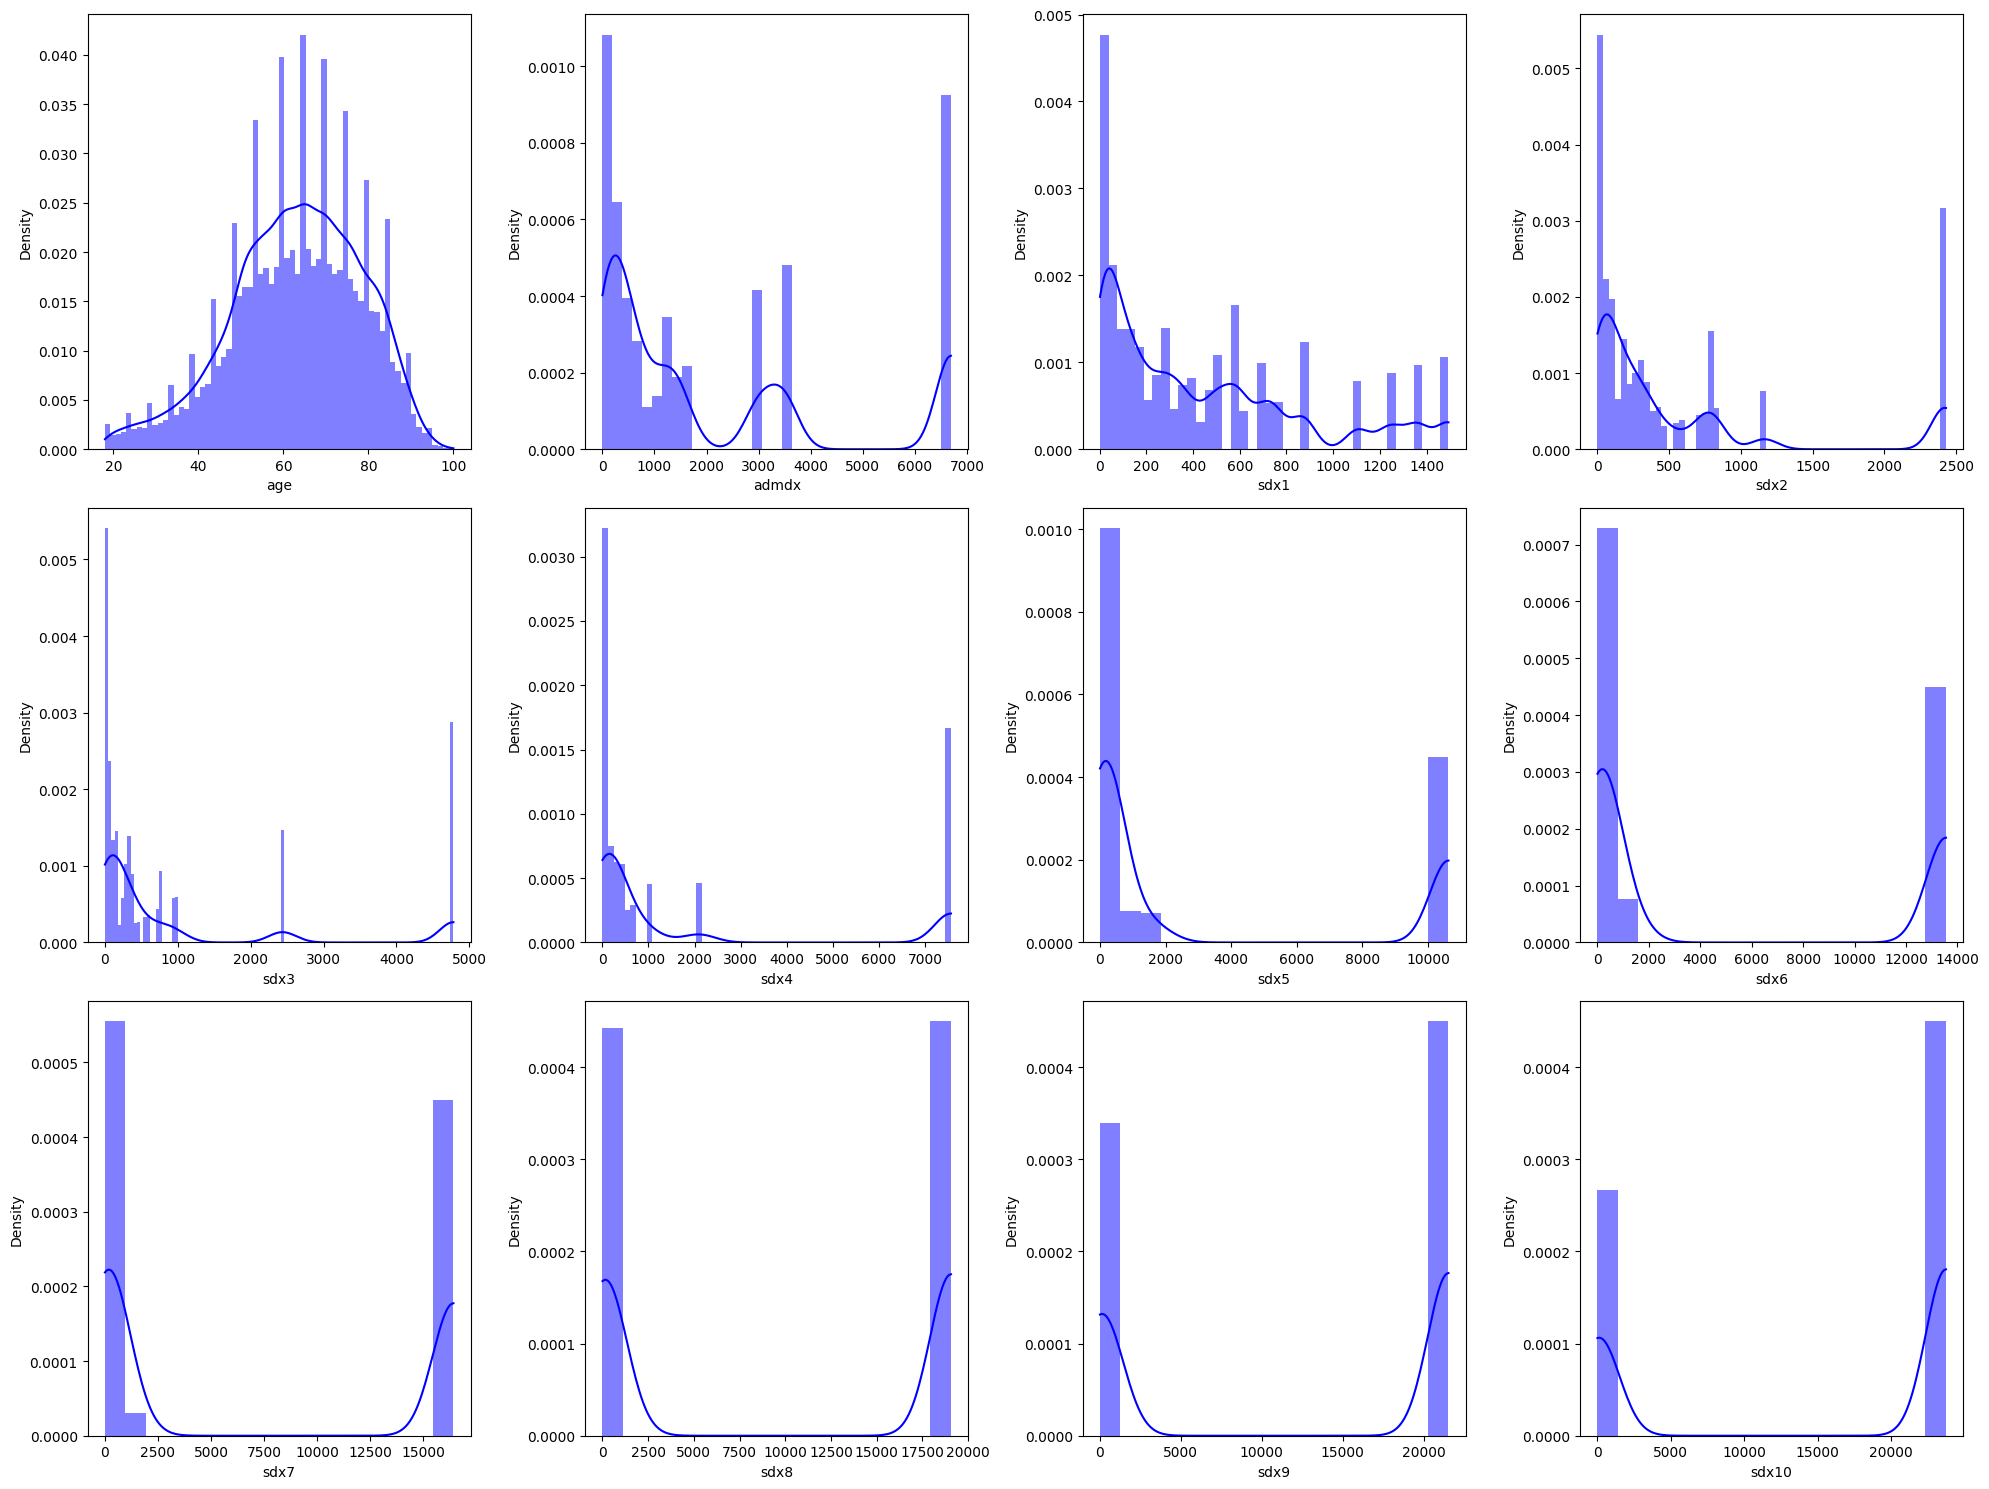

In [31]:
# checking numerical features distribution
plt.figure(figsize = (20, 15))
plotnumber = 1
for column in num_cols:
    if plotnumber <= 14:
        ax = plt.subplot(3, 4, plotnumber)
        sns.histplot (colectomy_cci_var[column], color = 'blue', kde = True, stat = "density", linewidth = 0)
        plt.xlabel(column)
    
        
    plotnumber += 1

plt.tight_layout()
plt.show()

/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_33492/3725035952.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_33492/3725035952.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_33492/3725035952.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.cou

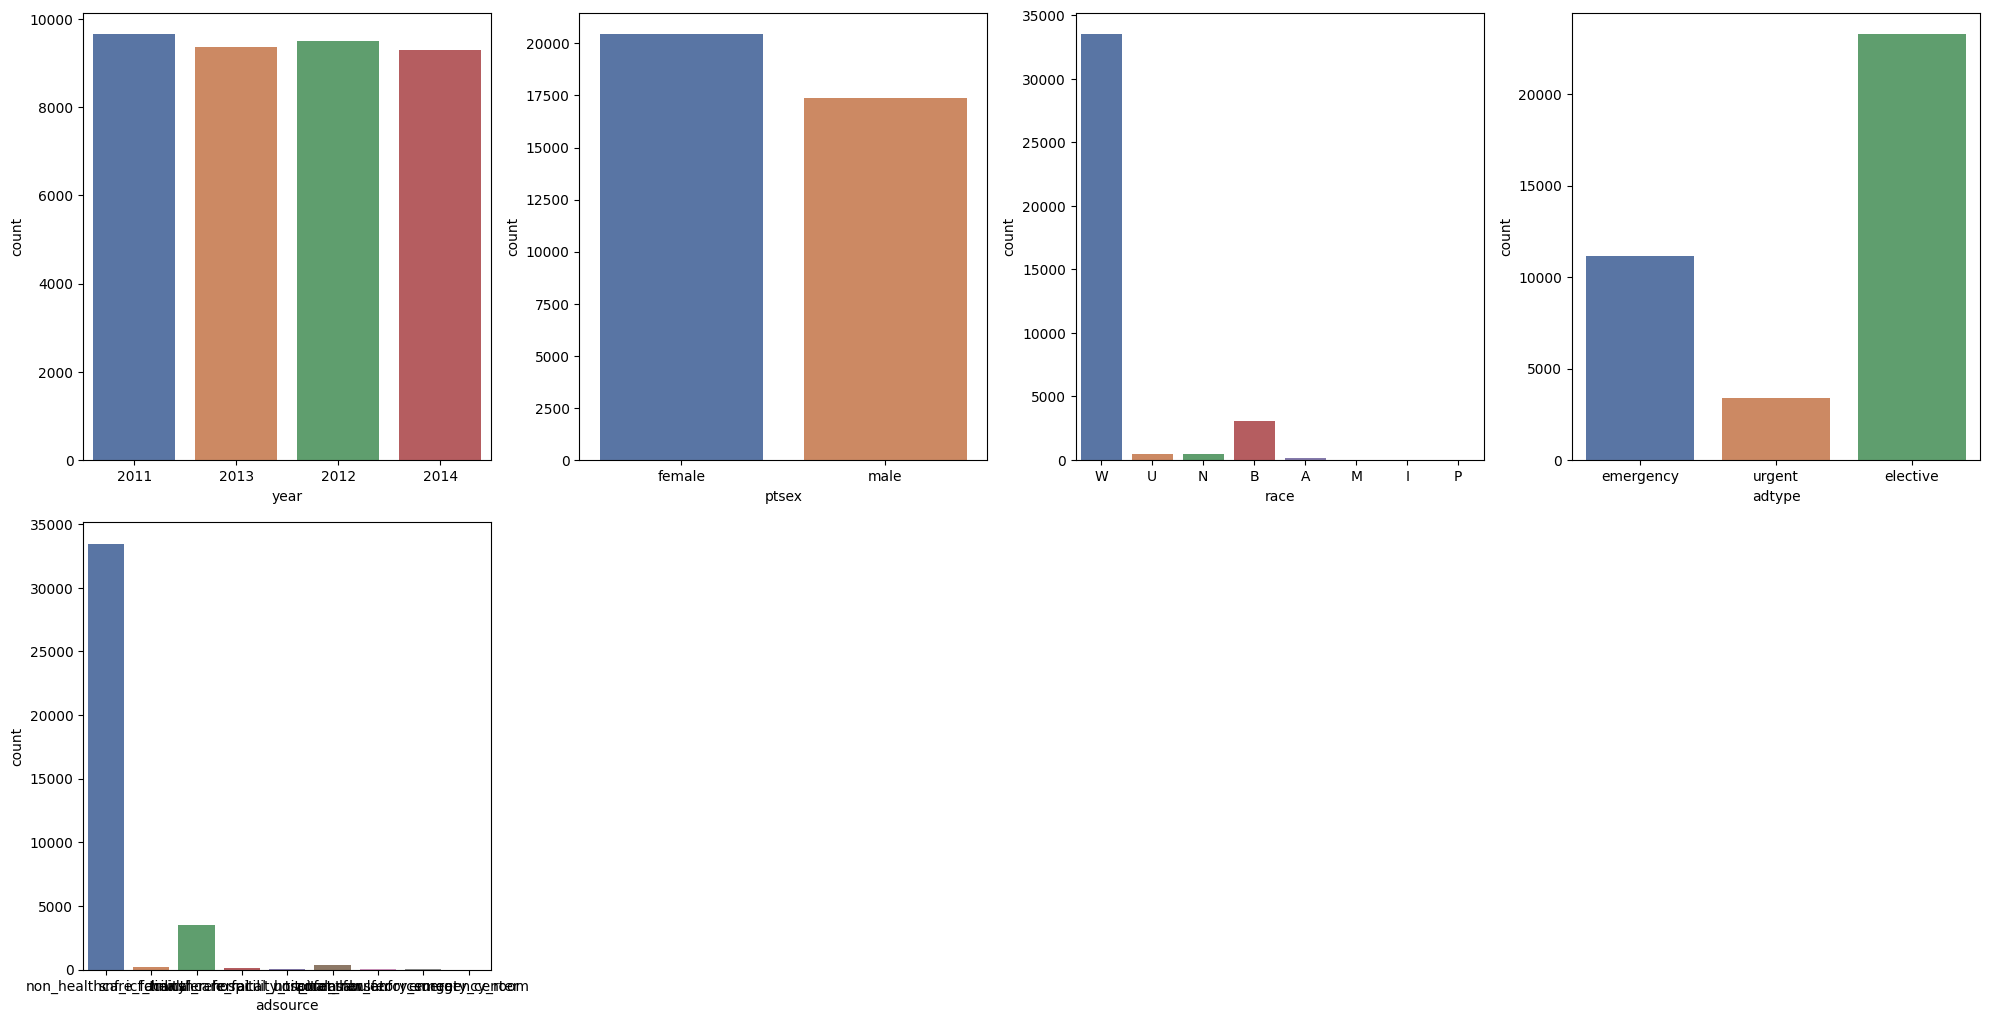

In [32]:
# looking at categorical columns

plt.figure(figsize = (20, 15))
plotnumber = 1
for column in cat_cols:
    if plotnumber <= 11:
        ax = plt.subplot(3, 4, plotnumber)
        sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

In [33]:
colectomy_cci_var_X = colectomy_cci_var[features]
colectomy_cci_var_y = colectomy_cci_var['pdx']

# One-Hot Encoding
colectomy_cci_var_X = pd.get_dummies(colectomy_cci_var_X, columns = dummy_features)

# Split Data
train_X, test_X, train_y, test_y = train_test_split(colectomy_cci_var_X, colectomy_cci_var_y, test_size = 0.2, random_state = 0)

# Label Encoding
encoder = LabelEncoder()
label_encoder = encoder.fit(train_y)
train_y = label_encoder.transform(train_y)
test_y = label_encoder.transform(test_y)

# Normalize Data
normalize_features = list(set(features) - set(dummy_features))

scaler = MinMaxScaler()

train_X_normalized = train_X.copy()
test_X_normalzied = test_X.copy()

normalizer = scaler.fit(train_X_normalized[normalize_features])

train_X_normalized[normalize_features] = normalizer.transform(train_X_normalized[normalize_features])
test_X_normalzied[normalize_features] = normalizer.transform(test_X_normalzied[normalize_features])

In [34]:
X_train = train_X_normalized
X_test = test_X_normalzied
Y_train = train_y
Y_test = test_y

# Training Models

In [35]:
# Random Forest
clf_rand_forest = RandomForestClassifier()
clf_rand_forest.fit(X_train, Y_train)

RandomForestClassifier()

In [36]:
# SVM
clf_svm = svm.SVC(kernel = 'linear')
clf_svm.fit(X_train, Y_train)

SVC(kernel='linear')

In [37]:
# Naive Bayes
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, Y_train)

GaussianNB()

In [38]:
# Logistic Regression
clf_log = LogisticRegression(solver = 'lbfgs', max_iter = 2500)
clf_log.fit(X_train, Y_train)

LogisticRegression(max_iter=2500)

In [39]:
# KNN
clf_knn = KNeighborsClassifier(n_neighbors = 5)
clf_knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [40]:
# XG Boost
clf_xgb = XGBClassifier(objective = 'multi:softmax', 
                        learning_rate = 0.5, 
                        max_depth = 5, 
                        n_estimators = 150, 
                        eval_metric = 'mlogloss',  
                        use_label_encoder = False)
clf_xgb.fit(X_train, Y_train)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:01:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [41]:
# Decision Tree
clf_dtc = DecisionTreeClassifier()
clf_dtc.fit(X_train, Y_train)

DecisionTreeClassifier()

In [ ]:
# Ada Boost
clf_ada = AdaBoostClassifier(estimator = clf_dtc)
clf_ada.fit(X_train, Y_train)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier())

# Evaluation

### Random Forest

#### Classification Report

In [49]:
Y_pred = clf_rand_forest.predict(X_test)

rand_forest_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {rand_forest_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.4422848076160254
Mean Absolute Error: 34.68226894089647
Mean Squared Error: 3995.051434615893
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         5
           1       1.00      0.00      0.00         6
           2       1.00      0.00      0.00         1
           3       1.00      0.00      0.00         2
           4       0.00      0.00      0.00         5
           5       1.00      0.00      0.00         3
           6       1.00      0.00      0.00        11
           7       0.00      0.00      0.00         2
           8       1.00      0.00      0.00         2
           9       1.00      0.00      0.00         4
          10       0.21      0.43      0.28       149
          11       1.00      0.00      0.00         2
          12       1.00      0.00      0.00         3
          13       0.00      0.00      0.00         7
          14       1.00      0.17      0.29         6
     

### SVM

#### Classification Report

In [ ]:
Y_pred = clf_svm.predict(X_test)

svm_acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {svm_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

### Naive Bayes

#### Classification Report

In [ ]:
Y_pred = clf_gnb.predict(X_test)

gnb_acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {gnb_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.96      0.96      0.96        28

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80



### Logistic Regression

#### Classification Report

In [ ]:
Y_pred = clf_log.predict(X_test)

log_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {log_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.97      1.00      0.98        28

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



### KNN

#### Classification Report

In [ ]:
Y_pred = clf_knn.predict(X_test)

knn_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {knn_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

              precision    recall  f1-score   support

           0       0.92      0.63      0.75        52
           1       0.57      0.89      0.69        28

    accuracy                           0.73        80
   macro avg       0.74      0.76      0.72        80
weighted avg       0.79      0.72      0.73        80



### XG_Boost

#### Classification Report

In [ ]:
Y_pred = clf_xgb.predict(X_test)

xgb_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {xgb_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.93      1.00      0.97        28

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



### Decision Tree

#### Classification Report

In [ ]:
Y_pred = clf_dtc.predict(X_test)

dtc_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {dtc_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       0.90      1.00      0.95        28

    accuracy                           0.96        80
   macro avg       0.95      0.97      0.96        80
weighted avg       0.97      0.96      0.96        80



### Ada Boost

#### Classification Report

In [ ]:
Y_pred = clf_ada.predict(X_test)

ada_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {ada_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.93      1.00      0.97        28

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



# Model Comparison

In [59]:
models = pd.DataFrame({
    'Model' : [ 'Random Forest Classifier', 'SVM Classifier', 'Naive Bayes Classifier','KNN Classifier',
             'XG_Boost Classifier', 'Decision Tree Classifier', 'Ada_Boost Classifier'],
    'Score' : [rand_forest_acc, svm_acc, gnb_acc, knn_acc, xgb_acc, dtc_acc, ada_acc]
})


sorted_models = models.sort_values(by = 'Score', ascending = True)

fig = px.bar(data_frame = sorted_models, x = 'Score', y = 'Model',
       title = 'Models Comparison')

fig.show()